In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

insurance_df = pd.read_csv("../Data/insurance.csv")

insurance_df.head()

In [ ]:
# Feature Engineering

insurance_df = (
    pd.get_dummies(insurance_df, drop_first=True)
    .assign(
        age_sq = insurance_df["age"]**2,
        smoker_bmi_int = lambda x: x["smoker_yes"] * x["bmi"]
           )
)

In [ ]:
# Data Splitting

from sklearn.model_selection import train_test_split

X = sm.add_constant(insurance_df.drop(["charges"], axis=1))
y = insurance_df["charges"]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=2023)

In [ ]:
# Standardization

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X_train.values)
X_val = std.transform(X_valid.values)
X_te = std.transform(X_test.values)

In [ ]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1).fit(X_tr, y_train)

list(zip(X.columns, ridge_model.coef_))

In [ ]:
n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

train_scores = []
val_scores = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha).fit(X_tr, y_train)
    train_scores.append(ridge_model.score(X_tr, y_train))
    val_scores.append(ridge_model.score(X_val, y_valid))
    
scores_df = pd.DataFrame({
    "alpha": alphas,
    "training": train_scores,
    "validation": val_scores
})

scores_df[:150].set_index("alpha").plot() #[:150]

In [ ]:
scores_df.sort_values("validation", ascending=False)

In [ ]:
std = StandardScaler()
X_m = std.fit_transform(X.values)
X_te = std.transform(X_test.values)

In [ ]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.933).fit(X_m, y)

list(zip(X.columns, ridge_model.coef_))

In [ ]:
ridge_model.score(X_m, y)

In [ ]:
ridge_model.score(X_te, y_test)

In [ ]:
lr_model = sm.OLS(y, X).fit()

# lr_model.summary()

In [ ]:
from sklearn.metrics import r2_score as r2

r2(y_test, lr_model.predict(X_test))

# RidgeCV

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error as mae

n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv=5)

ridge_model.fit(X_m, y)
print(ridge_model.score(X_m, y))
print(mae(y, ridge_model.predict(X_m)))
print(ridge_model.alpha_)

In [ ]:
ridge_model.score(X_te, y_test)

## Lasso Regression

In [ ]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X_train.values)
X_val = std.transform(X_valid.values)
X_te = std.transform(X_test.values)

In [ ]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=50).fit(X_tr, y_train) # up strength to drop vars

list(zip(X.columns, lasso_model.coef_))

In [ ]:
n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

train_scores = []
val_scores = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha).fit(X_tr, y_train)
    train_scores.append(lasso_model.score(X_tr, y_train))
    val_scores.append(lasso_model.score(X_val, y_valid))
    
scores_df = pd.DataFrame({
    "alpha": alphas,
    "training": train_scores,
    "validation": val_scores
})

scores_df.set_index("alpha").plot() #[:150]

In [ ]:
scores_df.sort_values("validation", ascending=False)

In [ ]:
lasso_model = Lasso(alpha=31.08).fit(X_m, y)

list(zip(X.columns, lasso_model.coef_))

In [ ]:
lasso_model.score(X_m, y)

In [ ]:
lasso_model.score(X_te, y_test)

In [ ]:
r2(y_test, lr_model.predict(X_test))

## LassoCV

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error as mae

n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv=5)

lasso_model.fit(X_m, y)
print(lasso_model.score(X_m, y))
print(mae(y, lasso_model.predict(X_m)))
print(lasso_model.alpha_)

In [ ]:
lasso_model.score(X_te, y_test)

In [ ]:
list(zip(X.columns, lasso_model.coef_))

### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

enet_model = ElasticNet(alpha=1, l1_ratio=.5).fit(X_tr, y_train)

print(
    f"Train Score: {round(enet_model.score(X_tr, y_train), 4)} "
    f"Valid Score: {round(enet_model.score(X_val, y_valid), 4)} "
)

In [ ]:
train_scores = []
val_scores = []

l1_ratios = np.linspace(.01, 1, 100)

for l1_ratio in l1_ratios:
    enet_model = ElasticNet(alpha=1, l1_ratio=l1_ratio).fit(X_tr, y_train)
    train_scores.append(enet_model.score(X_tr, y_train))
    val_scores.append(enet_model.score(X_val, y_valid))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(l1_ratios, train_scores, label="Train Scores")
ax.plot(l1_ratios, val_scores, label="Validation Scores")

ax.set_xlabel("L1_Ratio")
ax.set_ylabel("Prediction R2")

ax.spines[["top", "right"]].set_visible(False)
ax.legend()

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


l1_ratios = np.linspace(.01, 1, 100)
alphas = 10 ** np.linspace(-3, 3, n_alphas)

param_grid = {"alpha": alphas, "l1_ratio": l1_ratios}

eNet_model = ElasticNet()
grid = GridSearchCV(eNet_model, param_grid, scoring='r2', cv=5)
grid.fit(X_m, y)

In [ ]:
print(f"Best Params: {grid.best_params_}")
print(f"Best Score: {grid.best_score_}")

In [ ]:
eNet_final = ElasticNet(alpha=1.11, l1_ratio=1).fit(X_m, y)

eNet_final.score(X_m, y)

In [ ]:
eNet_final.score(X_te, y_test)

## Elastic Net CV

In [ ]:
from sklearn.linear_model import ElasticNetCV

alphas = 10 ** np.linspace(-3, 3, 200)
l1_ratios = np.linspace(.9, 1, 10) # .9, 1, 10

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)

enet_model.fit(X_m, y)
print(enet_model.score(X_m, y))
print(enet_model.score(X_te, y_test))
print(enet_model.alpha_)
print(enet_model.l1_ratio_)

### Tree Based Models

In [1]:
import pandas as pd

insurance_df = pd.read_csv("../Data/insurance.csv")

insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
from sklearn.model_selection import train_test_split

insurance_df = pd.get_dummies(insurance_df, drop_first=True)

X = insurance_df.drop(["charges"], axis=1)
y = insurance_df["charges"]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [8]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=6)

model.fit(X, y)

print(model.score(X, y))
print(model.score(X_test, y_test))

0.8969422048802109
0.8064393932849417


In [4]:
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1068,63,21.660,1,1,0,1,0,0
1018,54,35.815,3,0,0,1,0,0
995,39,23.275,3,0,0,0,0,0
1248,18,39.820,0,0,0,0,1,0
549,43,46.200,0,0,1,0,1,0


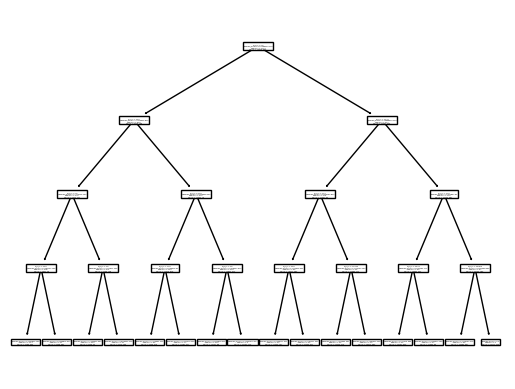

In [7]:
from sklearn.tree import plot_tree

plot_tree(model);

In [9]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(min_samples_leaf=5, n_estimators=1000, random_state=2023)

model = rf.fit(X, y)

print(model.score(X, y))
print(model.score(X_test, y_test))

0.9102561279621249
0.8571144812474996


In [10]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(min_samples_leaf=5, n_estimators=50, random_state=2023)

model = gb.fit(X, y)

print(model.score(X, y))
print(model.score(X_test, y_test))

0.883628745344029
0.8675330292228424
